# Coffee Shop Time Series Analysis: Data Preprocessing for Predicting Transactions and Analyzing Order Patterns

Because time series is that me expresso ☕. 

### Introduction

Hi, everyone. I will use this dataset for a project so I decided to share this notebook on how I engineered some features to predict the transaction data for next hour. It include some of the same plots made by other users, but also included rolling average and entropy calculation.

The idea of using transaction data instead of predicting sales directly is to accomodate for the fact that prices might change over time (something I might introduce to my project if I have time).

### Dataset Overview

Our dataset contains hourly transaction data from a coffee shop, including:
- Timestamp of transactions
- Total sales amount
- Number of transactions
- Types of coffee sold (Americano, Latte, Cappuccino, etc.)

### Project Goals

1. Understand temporal patterns in coffee shop transactions
2. Analyze the diversity of coffee orders using entropy
3. Engineer meaningful features from time-based data
5. Visualize insights using coffee-themed plots

### Why This Matters

Processing time series data is not always trivial. The most interesting aspect of this notebook might be to show how to split time series data using `Scikit-learn` function `TimeSeriesSplit` and how design feature such as the day of week and entropy.

### A Taste of What's to Come

We'll be using various data science techniques, including:
- Feature engineering with rolling averages
- Entropy calculation for order diversity
- Custom visualizations with a coffee-inspired color palette

So grab your favorite coffee, and let's dive into the data!

## Preprocessing the data

In [1]:
!pip install holidays

Importing the data

In [2]:
import pandas as pd
import holidays as hd
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# plt.style.use('seaborn')

coffee_colors = [
    "#D2B48C",
    "#DEB887",
    "#F4A460",
    "#CD853F",
    "#D2691E",
    "#B87333",
    "#6F4E37",
    "#4A2C2A",
    "#2F1B1A",
]
data = pd.read_csv("data/raw/index.csv")

In [3]:
data.groupby("cash_type").count().reset_index()

,cash_type,date,datetime,card,money,coffee_name
0,card,807,807,807,807,807
1,cash,89,89,0,89,89


There is mostly card data in this dataset. This does not pose an issue for us. The card data id can provide a proxy for a person identifier (this isn't entirely true since people can have more than one card). I will drop this variable for now since it is not very helpful for our timeseries analysis.

In [4]:
data = data.drop("card", axis=1)

In [5]:
data.isna().sum()

date           0
datetime       0
cash_type      0
money          0
coffee_name    0
dtype: int64

There are no NA's in this dataset. We can proceed normaly to the next step. We will process the feature coffee_name to (possibly) use it to predict coffee type popularity (we will use to sum their values and transform it another variable `coffe_type_avg_timewindow`)

In [6]:
processed_columns = pd.get_dummies(data["coffee_name"], prefix="", prefix_sep="")

In [7]:
processed_columns.head()

,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
0,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,True,False
3,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True


In [8]:
data = pd.merge(data, processed_columns, left_index=True, right_index=True)
data = data.drop("coffee_name", axis=1)

In [9]:
data.head()

,date,datetime,cash_type,money,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
0,2024-03-01,2024-03-01 10:15:50.520,card,38.7,False,False,False,False,False,False,False,True
1,2024-03-01,2024-03-01 12:19:22.539,card,38.7,False,False,False,False,False,False,True,False
2,2024-03-01,2024-03-01 12:20:18.089,card,38.7,False,False,False,False,False,False,True,False
3,2024-03-01,2024-03-01 13:46:33.006,card,28.9,True,False,False,False,False,False,False,False
4,2024-03-01,2024-03-01 13:48:14.626,card,38.7,False,False,False,False,False,False,False,True


So far, so good. Now it is time to handle the timeseries. We will aggregate the data by hour and separate between weekend-working days.

In [10]:
data["datetime"] = pd.to_datetime(data["datetime"])
data.set_index("datetime", inplace=True)

hourly_data = data.resample("H").agg(
    {
        "money": "sum",
        "cash_type": "count",
        "Americano": "sum",
        "Americano with Milk": "sum",
        "Cappuccino": "sum",
        "Cocoa": "sum",
        "Cortado": "sum",
        "Espresso": "sum",
        "Hot Chocolate": "sum",
        "Latte": "sum",
    }
)

hourly_data["hour"] = hourly_data.index.hour
hourly_data["day_of_week"] = hourly_data.index.dayofweek
hourly_data["is_weekend"] = hourly_data["day_of_week"].isin([5, 6]).astype(int)

/tmp/ipykernel_413/1989454633.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = data.resample("H").agg(


In [11]:
hourly_data.head()

,money,cash_type,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte,hour,day_of_week,is_weekend
datetime,,,,,,,,,,,,,
2024-03-01 10:00:00,38.7,1,0,0,0,0,0,0,0,1,10,4,0
2024-03-01 11:00:00,0.0,0,0,0,0,0,0,0,0,0,11,4,0
2024-03-01 12:00:00,77.4,2,0,0,0,0,0,0,2,0,12,4,0
2024-03-01 13:00:00,67.6,2,1,0,0,0,0,0,0,1,13,4,0
2024-03-01 14:00:00,0.0,0,0,0,0,0,0,0,0,0,14,4,0


A tricky-er thing that can affect time series are holidays. I am not sure exactly where the dataset was collected but since the money currency is Ukranian Hryvnias, I tried to use the holidays date for Ukraine.   

In [12]:
ua_holidays = hd.UA(years=2024)
hourly_data.index = pd.to_datetime(hourly_data.index)
hourly_data["is_holiday"] = hourly_data.index.to_series().dt.date.isin(ua_holidays)

As you can see below, this does not really work because the holidays package does not have the holiday list for 2024 for Ukraine. I only kept the code above, to have a snipet of how to use it.

In [13]:
hourly_data.groupby("is_holiday").count()

,money,cash_type,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte,hour,day_of_week,is_weekend
is_holiday,,,,,,,,,,,,,
False,2916,2916,2916,2916,2916,2916,2916,2916,2916,2916,2916,2916,2916


In [14]:
hourly_data = hourly_data.drop("is_holiday", axis=1)

We will create the features that we discussed previously. To do so, we will create a rolling average (i.e. moving average). I have arbitraly chosen the values of three, six and twelve hours. We will now create a target variable and split features and target.

In [15]:
hourly_data["next_hour_transactions"] = hourly_data["cash_type"].shift(-1)
features = ["hour", "day_of_week", "is_weekend"]

coffee_types = [
    "Americano",
    "Americano with Milk",
    "Cappuccino",
    "Cocoa",
    "Cortado",
    "Espresso",
    "Hot Chocolate",
    "Latte",
]

window_sizes = [3, 6, 12]  # 3 hours, 6 hours, 12 hours
for coffee in coffee_types:
    for window in window_sizes:
        hourly_data[f"{coffee}_avg_{window}h"] = (
            hourly_data[coffee].rolling(window=window, min_periods=1).mean()
        )
        features.append(f"{coffee}_avg_{window}h")

for window in window_sizes:
    hourly_data[f"total_coffee_{window}h"] = (
        hourly_data[coffee_types]
        .rolling(window=window, min_periods=1)
        .sum()
        .sum(axis=1)
    )
    features.append(f"total_coffee_{window}h")

for col in ["money", "cash_type"]:
    hourly_data[f"prev_{col}"] = hourly_data[col].shift(1)
    features.append(f"prev_{col}")

After seeing some dataviz, I decided to also add a feature of to try to capture the variability in coffee types. It seems a reasonable assumption to think that if I sell more types of coffee, I am selling more coffee.

In [16]:
def calculate_coffee_entropy(row):
    coffee_types = [
        "Americano",
        "Americano with Milk",
        "Cappuccino",
        "Cocoa",
        "Cortado",
        "Espresso",
        "Hot Chocolate",
        "Latte",
    ]
    counts = row[coffee_types]
    total = counts.sum()
    if total == 0:
        return 0
    probabilities = counts / total
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy


hourly_data["coffee_entropy"] = hourly_data.apply(calculate_coffee_entropy, axis=1)
features.append("coffee_entropy")

In [17]:
hourly_data = hourly_data.dropna()

target = "next_hour_transactions"

X = hourly_data[features]
y = hourly_data[target]

## Time for some data visualizations! 

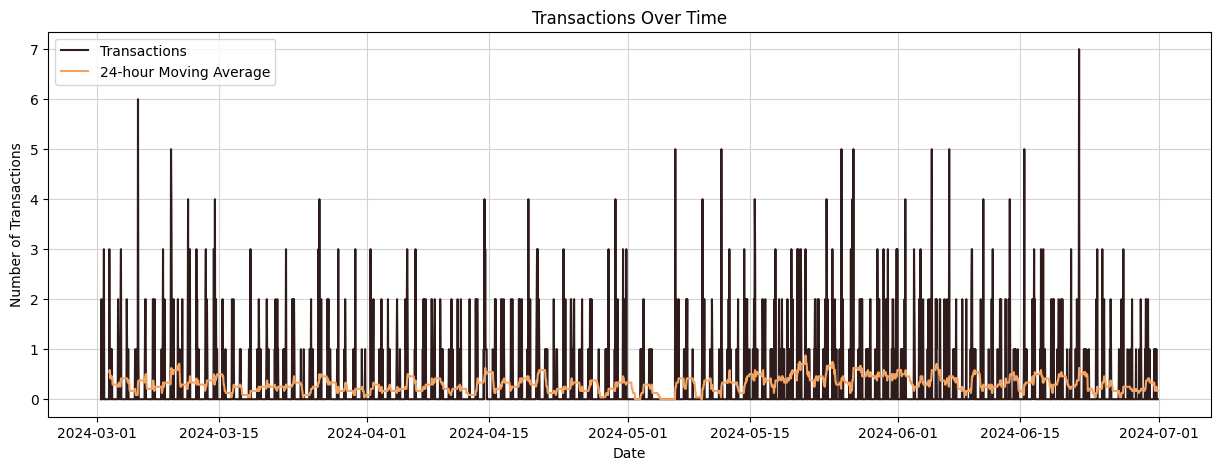

In [18]:
plt.figure(figsize=(15, 5))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["#2F1B1A", "#F4A460"])
plt.plot(hourly_data.index, hourly_data["cash_type"], label="Transactions")
plt.plot(
    hourly_data.index,
    hourly_data["cash_type"].rolling(24).mean(),
    label="24-hour Moving Average",
)
ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey")
plt.title("Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.legend()
plt.show()

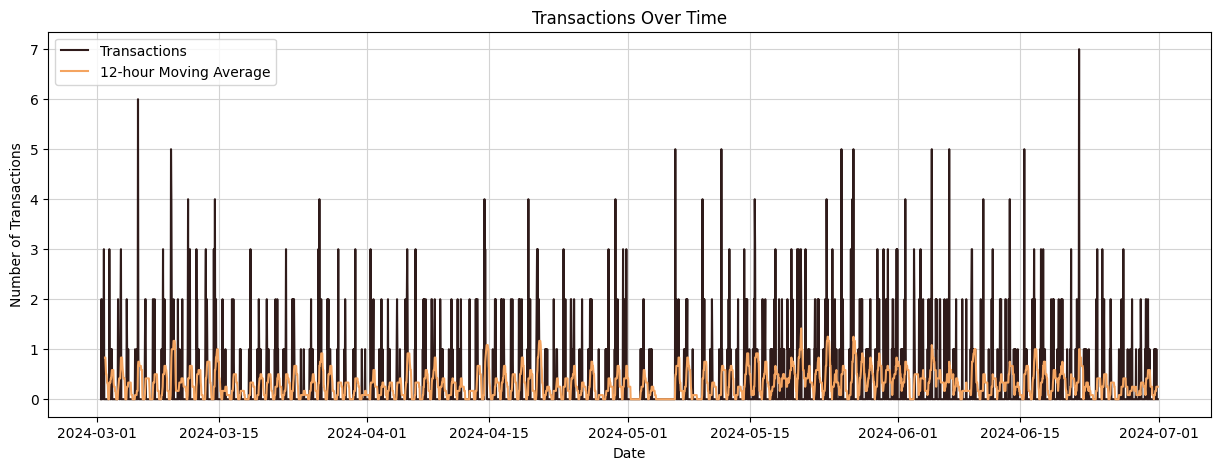

In [19]:
plt.figure(figsize=(15, 5))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["#2F1B1A", "#F4A460"])
plt.plot(hourly_data.index, hourly_data["cash_type"], label="Transactions")
plt.plot(
    hourly_data.index,
    hourly_data["cash_type"].rolling(12).mean(),
    label="12-hour Moving Average",
)
ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey")
plt.title("Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.legend()
plt.show()

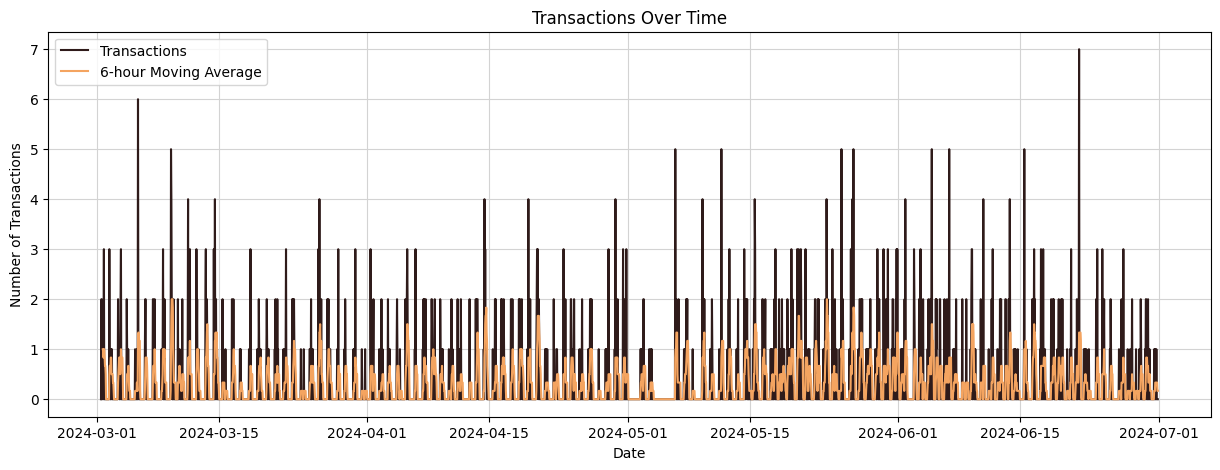

In [20]:
plt.figure(figsize=(15, 5))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["#2F1B1A", "#F4A460"])
plt.plot(hourly_data.index, hourly_data["cash_type"], label="Transactions")
plt.plot(
    hourly_data.index,
    hourly_data["cash_type"].rolling(6).mean(),
    label="6-hour Moving Average",
)
ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey")
plt.title("Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.legend()
plt.show()

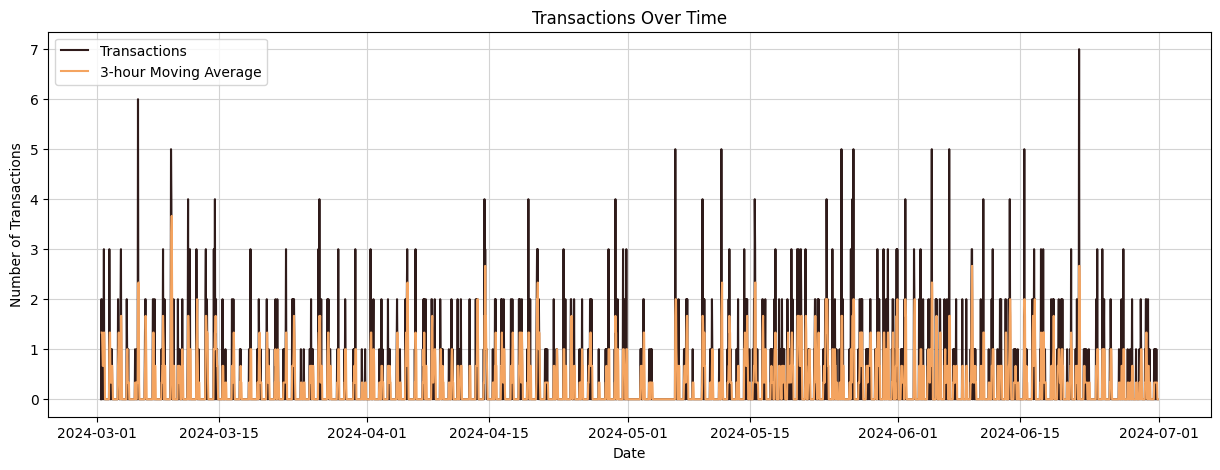

In [21]:
plt.figure(figsize=(15, 5))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["#2F1B1A", "#F4A460"])
plt.plot(hourly_data.index, hourly_data["cash_type"], label="Transactions")
plt.plot(
    hourly_data.index,
    hourly_data["cash_type"].rolling(3).mean(),
    label="3-hour Moving Average",
)
ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey")
plt.title("Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.legend()
plt.show()

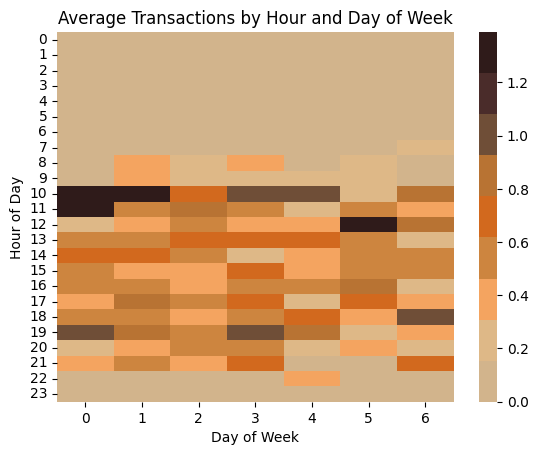

In [22]:
pivot = hourly_data.pivot_table(
    index=hourly_data.index.hour,
    columns=hourly_data.index.dayofweek,
    values="cash_type",
    aggfunc="mean",
)
sns.heatmap(pivot, cmap=coffee_colors)
plt.title("Average Transactions by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.show()

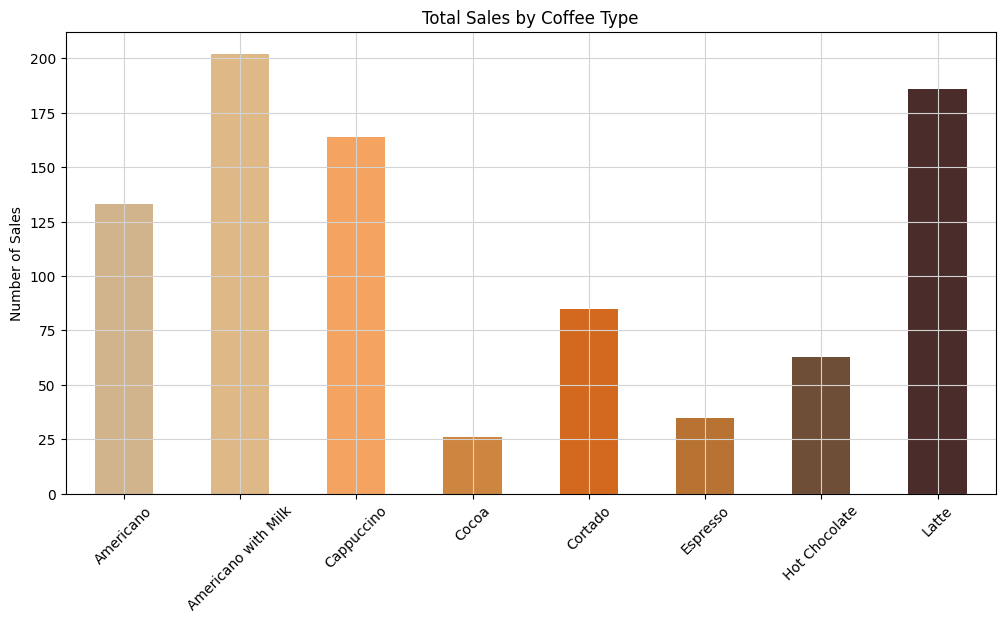

In [23]:
coffee_types = [
    "Americano",
    "Americano with Milk",
    "Cappuccino",
    "Cocoa",
    "Cortado",
    "Espresso",
    "Hot Chocolate",
    "Latte",
]



plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey") 

hourly_data[coffee_types].sum().plot(
    kind="bar", color=coffee_colors[: len(coffee_types)]
)
ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey")
plt.title("Total Sales by Coffee Type")
plt.ylabel("Number of Sales")
plt.xticks(rotation=45)
plt.show()

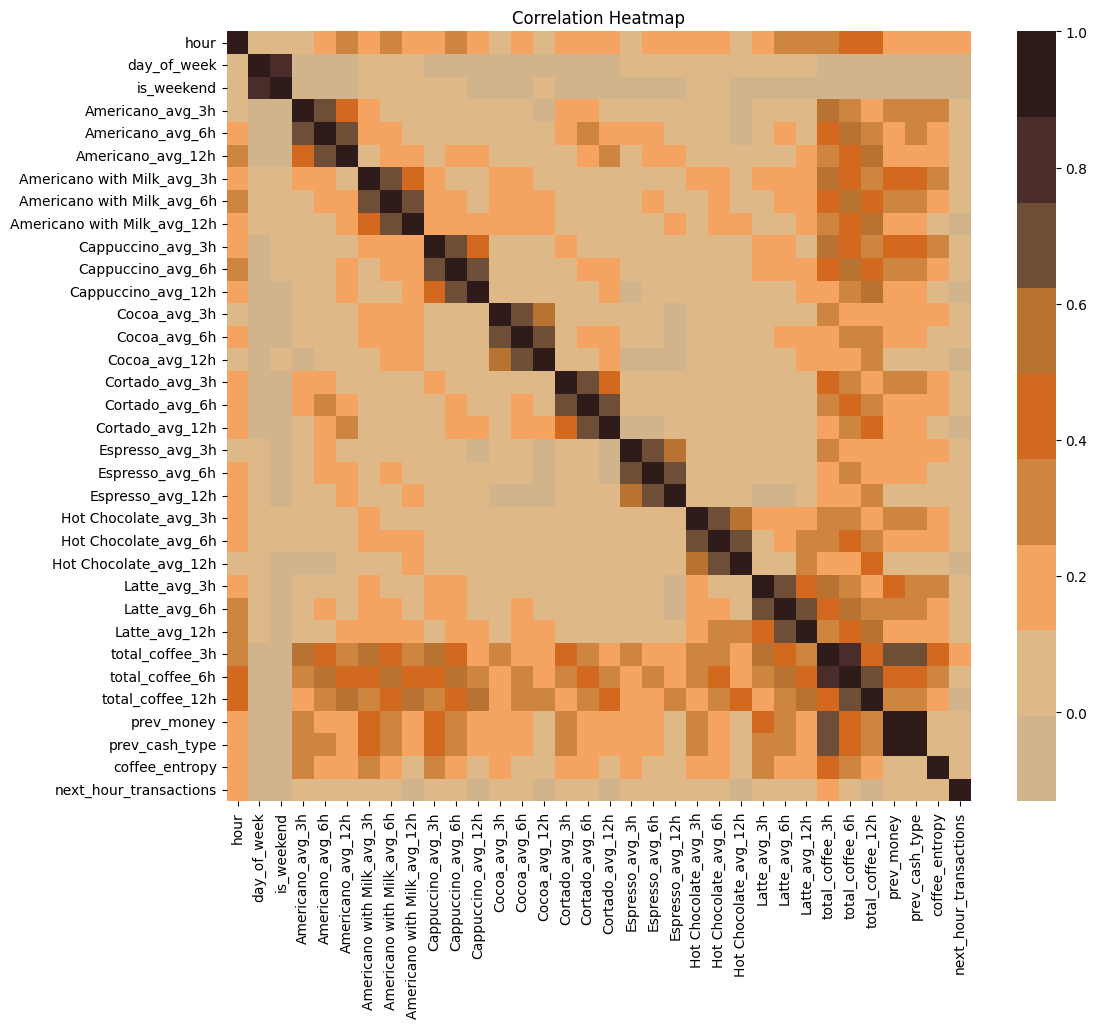

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    hourly_data[features + ["next_hour_transactions"]].corr(),
    annot=False,
    cmap=coffee_colors,
)
plt.title("Correlation Heatmap")
plt.show()

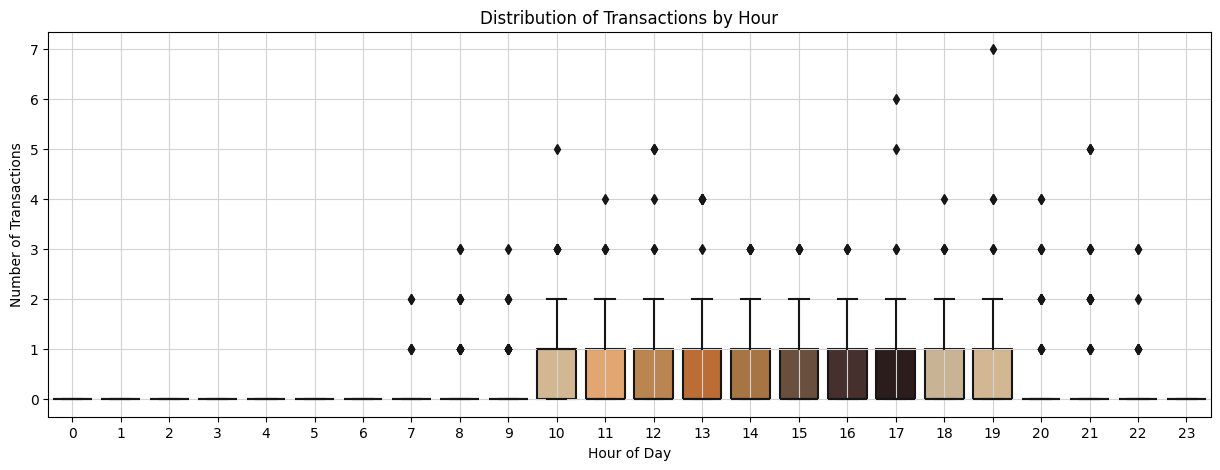

In [25]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=hourly_data.index.hour, y=hourly_data["cash_type"], palette=coffee_colors)
ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey")
plt.title("Distribution of Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.show()

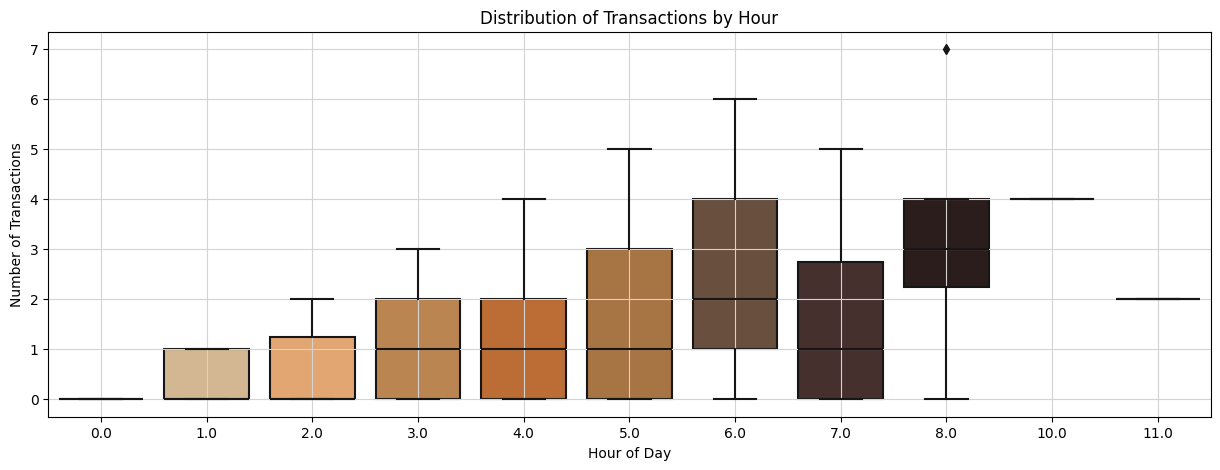

In [26]:
plt.figure(figsize=(15, 5))
sns.boxplot(
    x=hourly_data.total_coffee_3h, y=hourly_data["cash_type"], palette=coffee_colors
)
ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey")
plt.title("Distribution of Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.show()

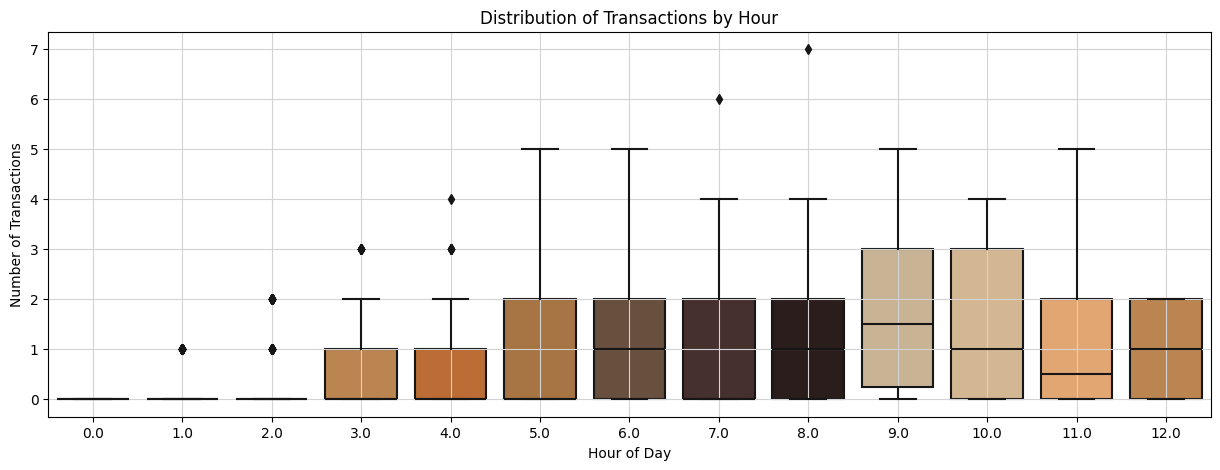

In [27]:
plt.figure(figsize=(15, 5))
sns.boxplot(
    x=hourly_data.total_coffee_6h, y=hourly_data["cash_type"], palette=coffee_colors
)
ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey")
plt.title("Distribution of Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.show()

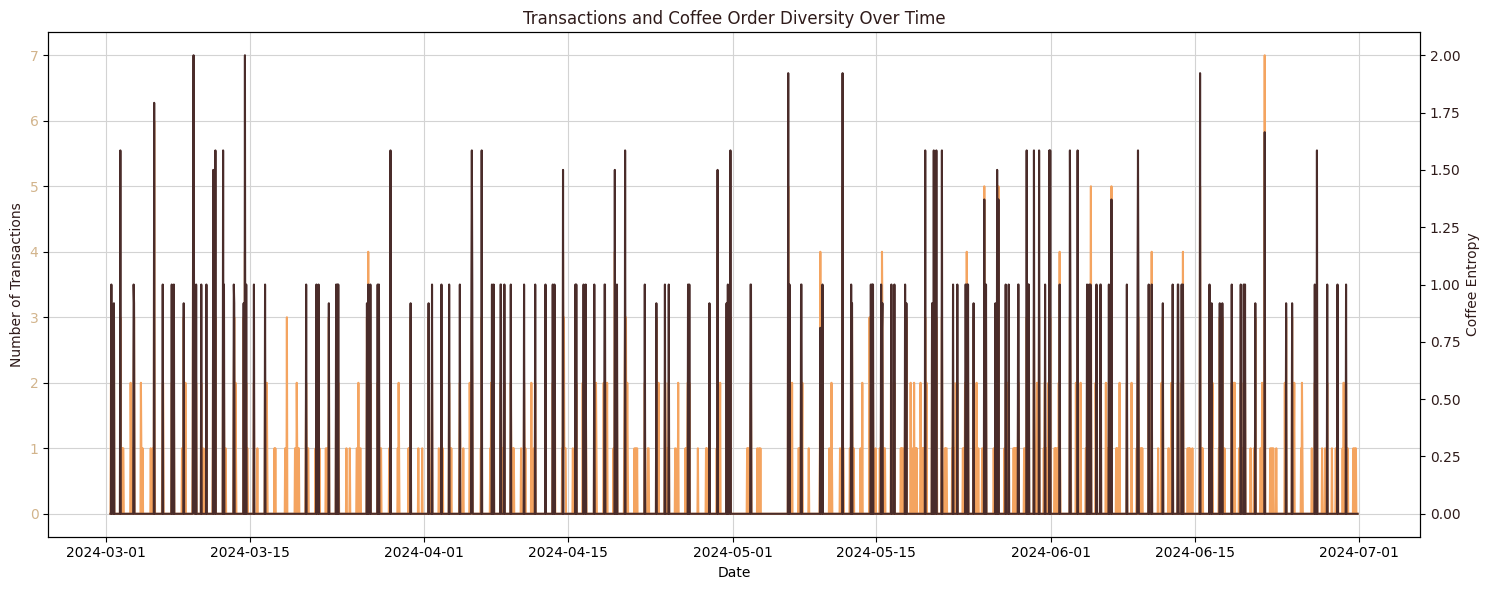

In [28]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel("Date")
ax1.set_ylabel("Number of Transactions", color=coffee_colors[-1])
ax1.plot(
    hourly_data.index,
    hourly_data["cash_type"],
    color=coffee_colors[2],
    label="Transactions",
)
ax1.tick_params(axis="y", labelcolor=coffee_colors[0])
ax1.set_facecolor("white")
ax1.grid(color="lightgrey")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("Coffee Entropy", color=coffee_colors[-1])
ax2.plot(
    hourly_data.index,
    hourly_data["coffee_entropy"],
    color=coffee_colors[-2],
    label="Coffee Entropy",
)
ax2.tick_params(axis="y", labelcolor=coffee_colors[-1])

plt.title("Transactions and Coffee Order Diversity Over Time", color=coffee_colors[-1])
fig.tight_layout()
plt.show()

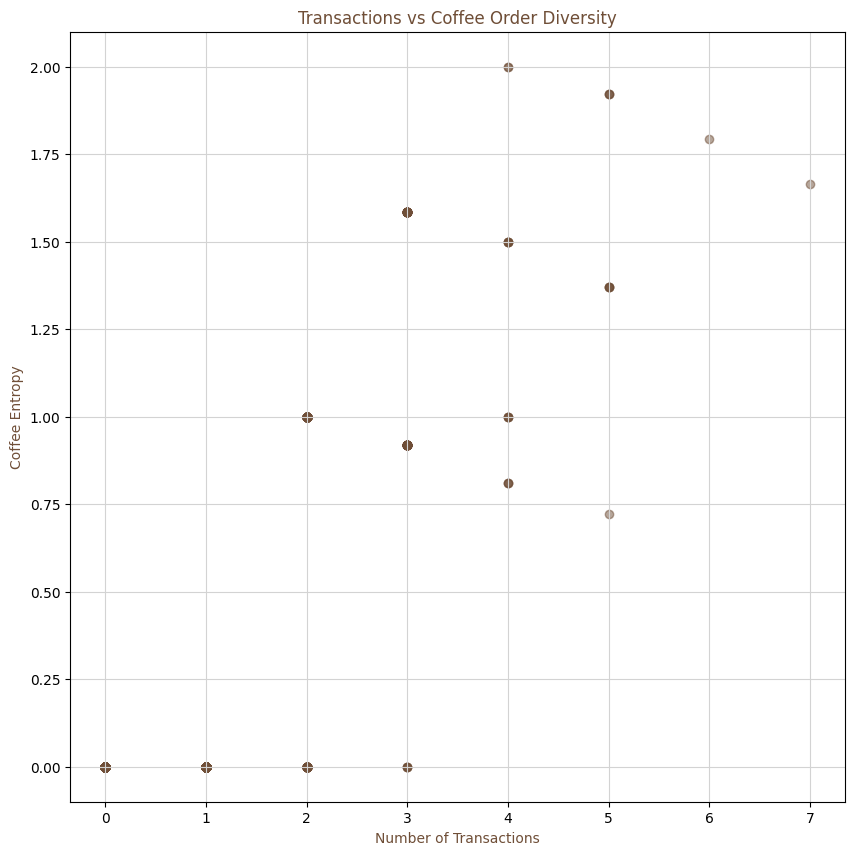

In [29]:
plt.figure(figsize=(10, 10))
plt.scatter(
    hourly_data["cash_type"],
    hourly_data["coffee_entropy"],
    alpha=0.5,
    color=coffee_colors[6],
)
ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey")
plt.title("Transactions vs Coffee Order Diversity", color=coffee_colors[-3])
plt.xlabel("Number of Transactions", color=coffee_colors[-3])
plt.ylabel("Coffee Entropy", color=coffee_colors[-3])
plt.show()

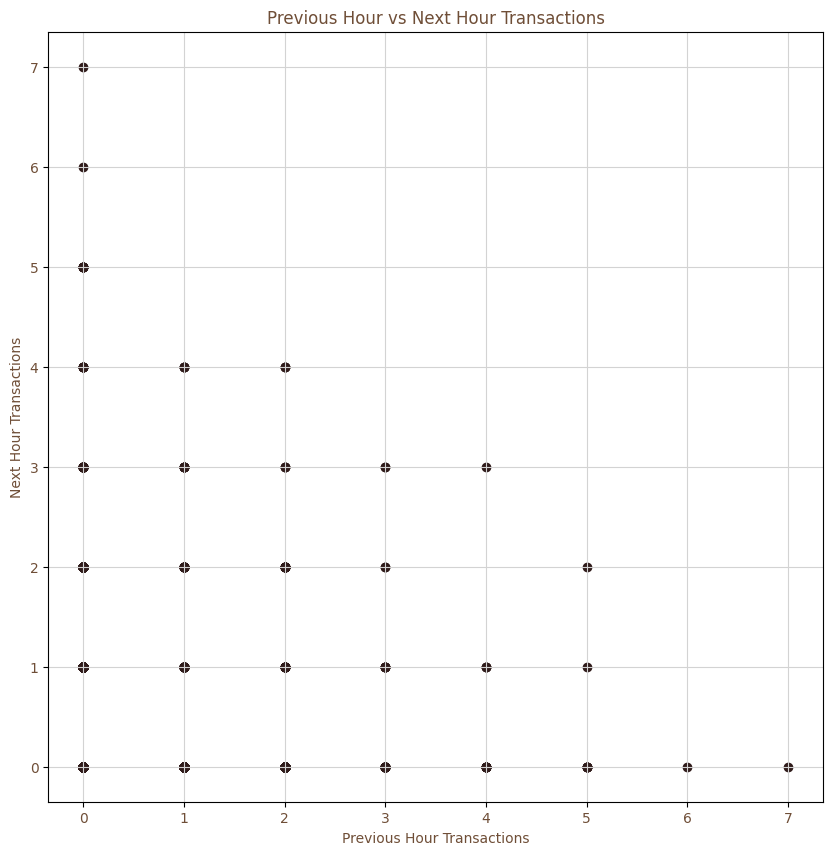

In [30]:
plt.figure(figsize=(10, 10))
plt.scatter(
    hourly_data["prev_cash_type"],
    hourly_data["next_hour_transactions"],
    color=coffee_colors[-1],
)

ax = plt.gca()
ax.set_facecolor("white")
ax.grid(color="lightgrey")

plt.title("Previous Hour vs Next Hour Transactions", color=coffee_colors[-3])
plt.xlabel("Previous Hour Transactions", color=coffee_colors[-3])
plt.ylabel("Next Hour Transactions", color=coffee_colors[-3])
plt.xticks(color=coffee_colors[-3])
plt.yticks(color=coffee_colors[-3])

plt.show()

# Splitting the dataset into train/test

Now that we have all of elements, it is time to split the data into training and test. For more details on how this function works, please see the Scikit-learn documentation (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [31]:
X_train_splits = []
X_test_splits = []
y_train_splits = []
y_test_splits = []

hourly_data = hourly_data.sort_index()
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=24)
for train_index, test_index in tscv.split(hourly_data):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_splits.append(X_train)
    X_test_splits.append(X_test)
    y_train_splits.append(y_train)
    y_test_splits.append(y_test)

/tmp/ipykernel_413/298023951.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]


In [32]:
for i in range(0, len(X_train_splits)):
    print(f"Split {i}:")
    print("X_train shape:", X_train_splits[i].shape)
    print("X_test shape:", X_test_splits[i].shape)
    print("y_train shape:", y_train_splits[i].shape)
    print("y_test shape:", y_test_splits[i].shape)
    print()

Split 0:
X_train shape: (2794, 33)
X_test shape: (24, 33)
y_train shape: (2794,)
y_test shape: (24,)

Split 1:
X_train shape: (2818, 33)
X_test shape: (24, 33)
y_train shape: (2818,)
y_test shape: (24,)

Split 2:
X_train shape: (2842, 33)
X_test shape: (24, 33)
y_train shape: (2842,)
y_test shape: (24,)

Split 3:
X_train shape: (2866, 33)
X_test shape: (24, 33)
y_train shape: (2866,)
y_test shape: (24,)

Split 4:
X_train shape: (2890, 33)
X_test shape: (24, 33)
y_train shape: (2890,)
y_test shape: (24,)



If you want to save the dataset, you can do by doing this.

In [33]:
for i in range(0, len(X_train_splits)):
    X_train_splits[i].to_csv(f"data/processed/X_train_split_{i}.csv", index=False)
    X_test_splits[i].to_csv(f"data/processed/X_test_split_{i}.csv", index=False)
    y_train_splits[i].to_csv(f"data/processed/y_train_split_{i}.csv", index=False)
    y_test_splits[i].to_csv(f"data/processed/y_test_split_{i}.csv", index=False)

We don't actually need that for our data, so we will save processed hourly_data

In [34]:
hourly_data.to_csv("data/processed/hourly_data.csv")

And that is all for today. I hope you enjoyed this notebook.  From here you could just use the training and test splits to train your model